In [27]:
import numpy as np

In [28]:
import modules.experiment.events as expevents
import modules.experiment.fov as expfov
import modules.eas_reconstruction as eas

import modules.plots.eas as easplots

from modules_reloader import reloader

relmod = reloader(expevents, eas, expfov, easplots)

In [29]:
relmod()

In [30]:
processor = expevents.EventProcessor(N=45, verbosity=3, load_rir=False, min_signal_significance=4.0)
L = 10
N = processor.N

In [31]:
event_id = 10685
event = expevents.Event(event_id)

In [32]:
x_fov, y_fov, t_means, t_stds = processor.get_arrival_times(event)

In [33]:
print(f'{len(x_fov)} points')

40 points


In [34]:
popt, perr, in_fit_mask = eas.adaptive_excluding_fit(
    x_fov, y_fov, t_means, t_stds, acceptable_angle_between=2, absolute_distance_exclusion=True
)

print(f'{np.sum(in_fit_mask)} points left in fit')

30 points left in fit


In [35]:
def rad2deg(r):
    return 180 * r / np.pi

In [36]:
print(f'theta = {rad2deg(popt[0])} +/- {rad2deg(perr[0])}')
print(f'phi = {rad2deg(popt[1])} +/- {rad2deg(perr[1])}')

theta = 23.317019021483713 +/- 14.054453076992424
phi = 108.14098004014143 +/- 42.541515038805095


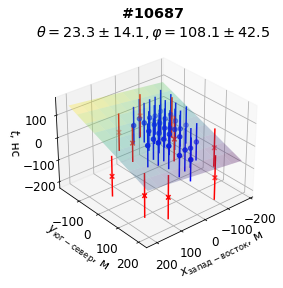

In [37]:
# %matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from modules.plots._shared import Figsize, _save_or_show


n_grid = 10
extension_factor = 1.1
x_lims = np.array([x_fov.min(), x_fov.max()])
x_plane = np.linspace(*(x_lims.mean() + extension_factor * (x_lims - x_lims.mean())), n_grid)
y_lims = np.array([y_fov.min(), y_fov.max()])
y_plane = np.linspace(*(y_lims.mean() + extension_factor * (y_lims - y_lims.mean())), n_grid)
xx_plane, yy_plane = np.meshgrid(x_plane, y_plane)
z_plane = eas.arrival_time_plane(
    np.concatenate((xx_plane.reshape(xx_plane.size, 1), yy_plane.reshape(yy_plane.size, 1)), axis=1),
    *popt
).reshape(xx_plane.shape)


fig = plt.figure(figsize=Figsize.SMALL.value)
ax = fig.add_subplot(111, projection='3d')

easplots.plot_scatter_with_errorbars(
    ax, x_fov, y_fov, t_means, t_stds,
    masks=[in_fit_mask, np.logical_not(in_fit_mask)],
    markers=['o', 'x'],
    colors=['b', 'r'],
    ylabel='$t$, нс',
)

surf = ax.plot_surface(xx_plane, yy_plane, z_plane, cmap='viridis', alpha=0.3)

ax.set_title(
    f'$\\bf{{\\#{event_id}}}$\n$\\theta = {rad2deg(popt[0]):.1f} \\pm {rad2deg(perr[0]):.1f}, \\varphi = {rad2deg(popt[1]):.1f} \\pm {rad2deg(perr[1]):.1f}$'
)
# print(f'theta = {rad2deg(popt[0])} +/- {rad2deg(perr[0])}')
# print(f'phi = {rad2deg(popt[1])} +/- {rad2deg(perr[1])}')

_save_or_show(f'showe-plane-approximation-{event_id}')